# Comp 3550 bioinformatics project

## Introduction

some stuff

# Program

## Libary setup

In [91]:

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.Blast import NCBIWWW, NCBIXML
import csv, os


## Functions

### Functions to convert Fasta Files to CSV

In [92]:
# Functions to convert fasta files to csv

def convertFastaToCsv(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        csv_writer = csv.writer(outfile)
        csv_writer.writerow(['PrimerPair', 'Direction', 'Sequence'])
        
        for line in infile:
            if line.strip() == '':
                continue
            if line.startswith('>'):
                parts = line[1:].strip().split('_')
                index = parts[1] if len(parts) > 2 else '1'
                directionLetter = parts[2].split(" ")[0] if len(parts) > 2 else parts[1].split(" ")[0]
                if directionLetter == 'F':
                    direction = 'forward'
                else:
                    direction = 'reverse'
            else:
                sequence = line.strip()
                csv_writer.writerow([index, direction, sequence])


In [93]:
def convertFastaFolderToCsv(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.fas'):
            input_file = os.path.join(input_folder, filename)
            output_file = os.path.join(output_folder, f'{filename}.csv')
            
            # Check if output file already exists
            if os.path.exists(output_file):
                output_file = os.path.join(output_folder, f'{filename}.csv')
                continue
            
            convertFastaToCsv(input_file, output_file)

### Functions for manipulating DataFrames to have the same shape

#### Manipulating Geneious DataFrames

##### Group Dataframe

In [94]:
def reshapeGroupGeneious(dataframe):
    df = dataframe
    
    # Create a mapping of primers to their paired primers
    primer_pairs = {}
    for index, row in df.iterrows():
        primer_pairs[row['Name']] = row['Paired Primer']
        primer_pairs[row['Paired Primer']] = row['Name']

    # Assign primer pair index
    df['PrimerPair'] = None
    current_index = 1
    for primer in primer_pairs:
        if df.loc[df['Name'] == primer, 'PrimerPair'].isnull().all():
            df.loc[df['Name'] == primer, 'PrimerPair'] = current_index
            df.loc[df['Name'] == primer_pairs[primer], 'PrimerPair'] = current_index
            current_index += 1

    
    df = df.rename(columns={
        'Sequence (with extension)': 'Sequence',
        })
    df = df[['PrimerPair',  'Direction', 'Sequence', 'Length (with extension)', 'Paired Primer','Name', 'Minimum', 'Maximum', '# Local Off-target Sites', '%GC', 'Hairpin Tm', 'Self Dimer Tm', 'Tm']]
    return df
    
    

##### Species Dataframe

In [95]:
def reshapeSpeciesGeneious(dataframe):
    df = dataframe
    
    
    df = df.rename(columns={
        'Sequence (with extension)': 'Sequence',
        })
    
    df = df[['SpeciesIndex','PrimerPair', 'SpeciesName', 'Direction', 'Sequence', 'Name' , 'Length (with extension)', 'Paired Primer', 'Minimum', 'Maximum', '# Local Off-target Sites', '%GC', 'Hairpin Tm', 'Self Dimer Tm', 'Tm']]
    
    return df

#### Manipulating PrimerQuest DataFrames

##### Group Dataframe

In [96]:
def reshapeGroupPrimerQuest(dataframe):
    df = dataframe
    # Extract primer pair number from AssaySet
    df['PrimerPair'] = df['AssaySet'].str.extract(r'Assay Set (\d+)').astype(int)

    # Rename Type to Direction and convert to lowercase
    df = df.rename(columns={'Type': 'Direction'})
    df['Direction'] = df['Direction'].str.replace(' Primer', '').str.lower()

    # Drop the old AssaySet column
    df = df.drop(columns=['AssaySet'])

    # Reorder columns
    df = df[['PrimerPair', 'Direction', 'Sequence', 'Start', 'Length', 'Tm', 'GC Percent', 'Amplicon']]
    
    return df


##### Species Dataframe

In [97]:
def reshapeSpeciesPrimerQuest(dataframe):
    df = dataframe
    # Extract primer pair number from AssaySet
    df['PrimerPair'] = df['AssaySet'].str.extract(r'Assay Set (\d+)').astype(int)

    # Extract SpeciesName from AssaySet
    df['SpeciesName'] = df['AssaySet'].str.extract(r'\(([^)]+)\)').astype(str)
    
    # Rename Type to Direction and convert to lowercase
    df = df.rename(columns={'Type': 'Direction'})
    df['Direction'] = df['Direction'].str.replace(' Primer', '').str.lower()
    
    # Drop the old AssaySet column
    df = df.drop(columns=['AssaySet'])

    # Reorder columns
    df = df[['PrimerPair', 'Direction','SpeciesName', 'SpeciesIndex', 'Sequence', 'Start', 'Length', 'Tm', 'GC Percent', 'Amplicon']]
    
    return df

#### Manipulating PrimerBlast DataFrames

##### Group Dataframe

In [98]:
def reshapeGroupPrimerBlast(dataframe):
    

    # Assuming your DataFrame is named df
    df = dataframe

    # Melt the DataFrame to long format
    df_long = pd.melt(df, id_vars=['Primer pair #', 'Product length'], 
                    value_vars=[col for col in df.columns if col.startswith('Forward') or col.startswith('Reverse')],
                    var_name='Attribute', value_name='Value')

    # Extract primer direction and attribute name
    df_long['Direction'] = df_long['Attribute'].apply(lambda x: 'Forward' if 'Forward' in x else 'Reverse')
    df_long['Attribute'] = df_long['Attribute'].apply(lambda x: x.replace('Forward primer ', '').replace('Reverse primer ', ''))

    # Pivot the DataFrame back to wide format
    df_wide = df_long.pivot_table(index=['Primer pair #', 'Product length', 'Direction'], 
                                columns='Attribute', values='Value', aggfunc='first').reset_index()

    # Reorder columns
    df_wide = df_wide[['Primer pair #', 'Direction', 'Sequence (5\'->3\')', 'Template strand', 'Length', 'Start', 'Stop', 'Tm', 'GC%', 'Self complementarity', 'Self 3\' complementarity', 'Product length']]

    df_wide = df_wide.rename(columns={
        'Sequence (5\'->3\')': 'Sequence',
        'Primer pair #': 'PrimerPair'
    })
    
    df_wide['Direction'] = df_wide['Direction'].str.lower()

    return df_wide

##### Species Dataframe

In [99]:
def reshapeSpeciesPrimerBlast(dataframe):
        # Assuming your DataFrame is named df
    df = dataframe

    # Melt the DataFrame to long format
    df_long = pd.melt(df, id_vars=['Primer pair #', 'Product length','SpeciesIndex', 'SpeciesName'], 
                    value_vars=[col for col in df.columns if col.startswith('Forward') or col.startswith('Reverse')],
                    var_name='Attribute', value_name='Value')

    # Extract primer direction and attribute name
    df_long['Direction'] = df_long['Attribute'].apply(lambda x: 'Forward' if 'Forward' in x else 'Reverse')
    df_long['Attribute'] = df_long['Attribute'].apply(lambda x: x.replace('Forward primer ', '').replace('Reverse primer ', ''))

    # Pivot the DataFrame back to wide format
    df_wide = df_long.pivot_table(index=['Primer pair #', 'Product length', 'Direction', 'SpeciesIndex', 'SpeciesName'], 
                                columns='Attribute', values='Value', aggfunc='first').reset_index()

    # Reorder columns
    df_wide = df_wide[['Primer pair #','SpeciesIndex','SpeciesName', 'Direction', 'Sequence (5\'->3\')', 'Template strand', 'Length', 'Start', 'Stop', 'Tm', 'GC%', 'Self complementarity', 'Self 3\' complementarity', 'Product length']]

    df_wide = df_wide.rename(columns={
        'Sequence (5\'->3\')': 'Sequence',
        'Primer pair #': 'PrimerPair'
    })
    
    df_wide['Direction'] = df_wide['Direction'].str.lower()

    return df_wide

#### Manipulating Primer3 DataFrames

##### Group Dataframe

##### Species Dataframe

### Functions to load species specific primers into dataframes

In [100]:
def load_csv_files_to_dataframe(folder_path):
    """
    Iterates over all .csv files in the specified folder and concatenates them into a single DataFrame.

    Parameters:
    folder_path (str): Path to the folder containing .csv files.

    Returns:
    pd.DataFrame: Combined DataFrame containing data from all .csv files.
    """
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    df_list = []
    speciesIndex = 1
    
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        # Add FamilyIndex and FamilyName columns
        df['SpeciesIndex'] = speciesIndex
        df['SpeciesName'] = os.path.basename(file_path).split(".")[0] # Remove .csv extension
        
        df_list.append(df)
        speciesIndex += 1  # Increment SpeciesIndex
        
        
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

In [101]:
def load_geneious_csv_to_dataframe(folder_path):
    """
    Iterates over all .csv files in the specified folder and concatenates them into a single DataFrame.

    Parameters:
    folder_path (str): Path to the folder containing .csv files.

    Returns:
    pd.DataFrame: Combined DataFrame containing data from all .csv files.
    """
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    df_list = []
    speciesIndex = 1
    
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df = reshapeGroupGeneious(df) # Defined later
        # Add FamilyIndex and FamilyName columns
        df['SpeciesIndex'] = speciesIndex
        df['SpeciesName'] = os.path.basename(file_path).split(".")[0] # Remove .csv extension
        
        df_list.append(df)
        speciesIndex += 1  # Increment SpeciesIndex
        
        
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

### Functions related to Blast Requests

In [102]:
import time

def makeBlastRequest(primerSequence):
    print(f"Making BLAST request for {primerSequence}...")
    startTime = time.time()
    result_handle = NCBIWWW.qblast(
        "blastn", 
        "nt", 
        primerSequence,
        word_size=7,
        megablast=True,
        perc_ident=85,
        expect = 10,
        hitlist_size=1000,
        filter="F",
        gapcosts="5 2",
        )
    endTime = time.time()
    print(f"BLAST request for {primerSequence} complete. Time taken: {endTime - startTime} seconds.")
    blastRecords = NCBIXML.parse(result_handle)
    
    return blastRecords

In [103]:
# def analyzeBlastResults(blastRecords):
#     print("Analyzing BLAST results...")
#     specificity_score = 0
#     total_hits = 0
#     off_target_hits = 0

#     for record in blastRecords:
#         for alignment in record.alignments:
#             total_hits += 1
#             for hsp in alignment.hsps:
#                 if hsp.expect < 0.01 and hsp.identities / hsp.align_length >= 0.8:
#                     off_target_hits += 1

#     if total_hits > 0:
#         specificity_score = 1 - (off_target_hits / total_hits)
#     else:
#         print(f'no hits found for {primerSequence}')
#     print(f"Specificity Score: {specificity_score}, Total Hits: {total_hits}, Off-Target Hits: {off_target_hits}")

#     return specificity_score, total_hits, off_target_hits

def analyzeBlastResults(blastRecords, primer_length, e_value_threshold=0.01, identity_threshold=0.8):
    print("Analyzing BLAST results...")
    total_hits = 0
    perfect_matches = 0
    off_target_hits = 0
    three_prime_mismatches = 0
    alignment_scores = []
    multiple_perfect_matches = 0  # New counter for alignments with multiple perfect matches

    for record in blastRecords:
        for alignment in record.alignments:
            total_hits += 1
            alignment_perfect_match_count = 0  # Count perfect matches within this alignment
            alignment_off_target = False
            alignment_three_prime_mismatch = False
            max_hsp_score = 0

            for hsp in alignment.hsps:
                max_hsp_score = max(max_hsp_score, hsp.score)
                
                # Check for perfect matches
                if hsp.identities == primer_length:
                    alignment_perfect_match_count += 1
                
                # Check for off-target hits
                if hsp.expect < e_value_threshold and hsp.identities / hsp.align_length >= identity_threshold:
                    alignment_off_target = True
                    
                    # Check for mismatches in the last 5 bases (3' end)
                    if len(hsp.query[-5:]) != len(hsp.match[-5:]):
                        alignment_three_prime_mismatch = True

            alignment_scores.append(max_hsp_score)
            if alignment_perfect_match_count > 0:
                perfect_matches += 1
                if alignment_perfect_match_count > 1:
                    multiple_perfect_matches += 1  # Count alignments with multiple perfect matches
            if alignment_off_target:
                off_target_hits += 1
            if alignment_three_prime_mismatch:
                three_prime_mismatches += 1

    if total_hits > 0:
        # Adjust specificity score to penalize multiple perfect matches
        multiple_match_penalty = multiple_perfect_matches / total_hits
        specificity_score = (perfect_matches / total_hits) * (1 - (off_target_hits / total_hits)) * (1 - (three_prime_mismatches / total_hits)) * (1 - multiple_match_penalty)
        averageHSPScore = np.mean(alignment_scores)
        # Calculate the difference between top two alignment scores
        if len(alignment_scores) >= 2:
            alignment_scores.sort(reverse=True)
            score_difference = alignment_scores[0] - alignment_scores[1]
        else:
            score_difference = 0
    else:
        specificity_score = 0
        score_difference = 0
        print(f'No hits found for this primer')

    print(f"Specificity Score: {specificity_score:.4f}")
    print(f"Total Hits: {total_hits}")
    print(f"Perfect Matches: {perfect_matches}")
    print(f"Alignments with Multiple Perfect Matches: {multiple_perfect_matches}")
    print(f"Off-Target Hits: {off_target_hits}")
    print(f"3' End Mismatches: {three_prime_mismatches}")
    print(f"Average HSP score: {averageHSPScore:.2f}")

    return specificity_score, total_hits, perfect_matches, multiple_perfect_matches, off_target_hits, three_prime_mismatches, averageHSPScore


## Main Program

### Data Setup


#### Convert to CSV Files for use with Pandas

In [104]:
foldersToConvert = ['data/group/primer3','data/species/primer3']

for folder in foldersToConvert:
    convertFastaFolderToCsv(folder, folder)

#### Initialize Group DataFrames

In [105]:
# Setup dataframes
groupGeneous = pd.read_csv('data/group/geneious/Entero grp-specific primers (GENEIOUS).csv')
groupPrimer3 = pd.read_csv('data/group/primer3/EnterobactericaeaP3.fas.csv')
groupPrimerBlast = pd.read_csv('data/group/primerBlast/Entero grp-specific primers (BLAST).csv')
groupPrimerQuest = pd.read_csv('Data/group/primerQuest/PrimerQuest family-specific.csv')

# Store dataframes in dictionary for dynamic usage and access later
groupData = {
    'Geneious': groupGeneous,
    'Primer3': groupPrimer3,
    'PrimerBlast': groupPrimerBlast,
    'PrimerQuest': groupPrimerQuest
}

##### Investigate shape of data frames


In [106]:
groupData['Geneious'].head()

,Name,Minimum,Maximum,Direction,Sequence (with extension),Length (with extension),Paired Primer,# Local Off-target Sites,%GC,Hairpin Tm,Self Dimer Tm,Tm
0,934 F,934,953,forward,GGGCTTGACATACACCGGAA,20,"1,130 R",0,55.0,NaN,9.5,60.0
1,916 F,916,935,forward,ACGCGAAGAACCTTACCTGG,20,"1,131 R",0,55.0,NaN,15.9,60.0
2,427 F,427,446,forward,ACGGTACCTGCAGAAGAAGC,20,953 R,0,55.0,NaN,17.4,60.0
3,275 F,275,294,forward,CCACACTGGGACTGAGACAC,20,"1,182 R",0,60.0,32.7,NaN,60.0
4,"1,182 R",1163,1182,reverse,TAGCATGTGTGAAGCCCTGG,20,275 F,0,55.0,NaN,NaN,60.0


In [107]:
groupData['Primer3'].head()

,PrimerPair,Direction,Sequence
0,1,forward,TGCCTGATGGAGGGGGATAA
1,1,reverse,GAGACTCAAGCCTGCCAGTT
2,2,forward,GGAACTGAGACACGGTCCAG
3,2,reverse,TTTAACCTTGCGGCCGTACT
4,3,forward,TGGTAGTCCACGCCGTAAAC


In [108]:
groupData['PrimerBlast'].head()

,Primer pair #,Forward primer Sequence (5'->3'),Forward primer Template strand,Forward primer Length,Forward primer Start,Forward primer Stop,Forward primer Tm,Forward primer GC%,Forward primer Self complementarity,Forward primer Self 3' complementarity,Reverse primer Sequence (5'->3'),Reverse primer Template strand,Reverse primer Length,Reverse primer Start,Reverse primer Stop,Reverse primer Tm,Reverse primer GC%,Reverse primer Self complementarity,Reverse primer Self 3' complementarity,Product length
0,1,AAGAAGCACCGGCTAACTCC,Plus,20.0,496.0,515.0,60.04,55.0,4.0,0.0,TTCACAACACGAGCTGACGA,Minus,20.0,1082.0,1063.0,59.90,50.0,4.0,2.0,587.0
1,2,TATTGCACAATGGGCGCAAG,Plus,20.0,366.0,385.0,59.83,50.0,6.0,2.0,GGAGTTAGCCGGTGCTTCTT,Minus,20.0,515.0,496.0,60.04,55.0,4.0,0.0,150.0
2,3,CGGTAATACGGAGGGTGCAA,Plus,20.0,529.0,548.0,59.82,55.0,5.0,2.0,GTTCTTCGCGTTGCATCGAA,Minus,20.0,980.0,961.0,59.84,50.0,6.0,2.0,452.0
3,4,TTCGATGCAACGCGAAGAAC,Plus,20.0,961.0,980.0,59.84,50.0,6.0,0.0,TTGCGGGACTTAACCCAACA,Minus,20.0,1103.0,1084.0,59.82,50.0,4.0,2.0,143.0
4,5,TCGTCAGCTCGTGTTGTGAA,Plus,20.0,1063.0,1082.0,59.90,50.0,4.0,1.0,TTGTAGCACGTGTGTAGCCC,Minus,20.0,1240.0,1221.0,60.32,55.0,6.0,0.0,178.0


In [109]:
groupData['PrimerQuest']

,AssaySet,Type,Sequence,Start,Length,Tm,GC Percent,Amplicon
0,Assay Set 1 (Consensus),Forward Primer,GATGTGCCCAGATGGGATTAG,220.0,21.0,62.233,52.381,NaN
1,Assay Set 1 (Consensus),Reverse Primer,GTGGATGTCAAGACCAGGTAAG,994.0,22.0,62.205,50.000,NaN
2,Assay Set 1 (Consensus),Product,NaN,NaN,NaN,NaN,NaN,775.0
3,Assay Set 2 (Consensus),Forward Primer,ACGGTAGCTAATACCGCATAAC,155.0,22.0,61.972,45.455,NaN
4,Assay Set 2 (Consensus),Reverse Primer,CCTCCAGATCTCTACGCATTTC,707.0,22.0,62.034,50.000,NaN
...,...,...,...,...,...,...,...,...
994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Investigate dataframes

In [110]:
groupData['Geneious'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       10 non-null     object 
 1   Minimum                    10 non-null     int64  
 2   Maximum                    10 non-null     int64  
 3   Direction                  10 non-null     object 
 4   Sequence (with extension)  10 non-null     object 
 5   Length (with extension)    10 non-null     int64  
 6   Paired Primer              10 non-null     object 
 7   # Local Off-target Sites   10 non-null     int64  
 8   %GC                        10 non-null     float64
 9   Hairpin Tm                 3 non-null      float64
 10  Self Dimer Tm              3 non-null      float64
 11  Tm                         10 non-null     float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.1+ KB


In [111]:
groupData['Primer3'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PrimerPair  20 non-null     int64 
 1   Direction   20 non-null     object
 2   Sequence    20 non-null     object
dtypes: int64(1), object(2)
memory usage: 612.0+ bytes


In [112]:
groupData['PrimerBlast'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Primer pair #                           11 non-null     object 
 1   Forward primer Sequence (5'->3')        10 non-null     object 
 2   Forward primer Template strand          10 non-null     object 
 3   Forward primer Length                   10 non-null     float64
 4   Forward primer Start                    10 non-null     float64
 5   Forward primer Stop                     10 non-null     float64
 6   Forward primer Tm                       10 non-null     float64
 7   Forward primer GC%                      10 non-null     float64
 8   Forward primer Self complementarity     10 non-null     float64
 9   Forward primer Self 3' complementarity  10 non-null     float64
 10  Reverse primer Sequence (5'->3')        10 non-null     object 


In [113]:
groupData['PrimerQuest'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AssaySet    15 non-null     object 
 1   Type        15 non-null     object 
 2   Sequence    10 non-null     object 
 3   Start       10 non-null     float64
 4   Length      10 non-null     float64
 5   Tm          10 non-null     float64
 6   GC Percent  10 non-null     float64
 7   Amplicon    5 non-null      float64
dtypes: float64(5), object(3)
memory usage: 62.6+ KB


##### Clean up dataframes

In [114]:
groupData['PrimerBlast'].dropna(inplace=True, subset=['Forward primer Template strand'])
groupData['PrimerBlast'].reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   index                                   10 non-null     int64  
 1   Primer pair #                           10 non-null     object 
 2   Forward primer Sequence (5'->3')        10 non-null     object 
 3   Forward primer Template strand          10 non-null     object 
 4   Forward primer Length                   10 non-null     float64
 5   Forward primer Start                    10 non-null     float64
 6   Forward primer Stop                     10 non-null     float64
 7   Forward primer Tm                       10 non-null     float64
 8   Forward primer GC%                      10 non-null     float64
 9   Forward primer Self complementarity     10 non-null     float64
 10  Forward primer Self 3' complementarity  10 non-null     float64
 

In [115]:
groupData['PrimerQuest'].dropna(inplace=True, subset=['Sequence'])
groupData['PrimerQuest'].reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       10 non-null     int64  
 1   AssaySet    10 non-null     object 
 2   Type        10 non-null     object 
 3   Sequence    10 non-null     object 
 4   Start       10 non-null     float64
 5   Length      10 non-null     float64
 6   Tm          10 non-null     float64
 7   GC Percent  10 non-null     float64
 8   Amplicon    0 non-null      float64
dtypes: float64(5), int64(1), object(3)
memory usage: 852.0+ bytes


##### Data Manipulation to have the same shape/column names 

In [116]:
groupData['PrimerBlast'] = reshapeGroupPrimerBlast(groupData['PrimerBlast'])
groupData['PrimerBlast'].head()


Attribute,PrimerPair,Direction,Sequence,Template strand,Length,Start,Stop,Tm,GC%,Self complementarity,Self 3' complementarity,Product length
0,1,forward,AAGAAGCACCGGCTAACTCC,Plus,20.0,496.0,515.0,60.04,55.0,4.0,0.0,587.0
1,1,reverse,TTCACAACACGAGCTGACGA,Minus,20.0,1082.0,1063.0,59.9,50.0,4.0,2.0,587.0
2,10,forward,GCAGAAGAAGCACCGGCTAA,Plus,20.0,492.0,511.0,60.67,55.0,4.0,1.0,89.0
3,10,reverse,TGCGCTTTACGCCCAGTAAT,Minus,20.0,580.0,561.0,60.39,50.0,5.0,2.0,89.0
4,2,forward,TATTGCACAATGGGCGCAAG,Plus,20.0,366.0,385.0,59.83,50.0,6.0,2.0,150.0


In [117]:
groupData['Geneious'] = reshapeGroupGeneious(groupData['Geneious'])
groupData['Geneious'].head()

,PrimerPair,Direction,Sequence,Length (with extension),Paired Primer,Name,Minimum,Maximum,# Local Off-target Sites,%GC,Hairpin Tm,Self Dimer Tm,Tm
0,1,forward,GGGCTTGACATACACCGGAA,20,"1,130 R",934 F,934,953,0,55.0,NaN,9.5,60.0
1,2,forward,ACGCGAAGAACCTTACCTGG,20,"1,131 R",916 F,916,935,0,55.0,NaN,15.9,60.0
2,3,forward,ACGGTACCTGCAGAAGAAGC,20,953 R,427 F,427,446,0,55.0,NaN,17.4,60.0
3,4,forward,CCACACTGGGACTGAGACAC,20,"1,182 R",275 F,275,294,0,60.0,32.7,NaN,60.0
4,4,reverse,TAGCATGTGTGAAGCCCTGG,20,275 F,"1,182 R",1163,1182,0,55.0,NaN,NaN,60.0


In [118]:
groupData['PrimerQuest'] = reshapeGroupPrimerQuest(groupData['PrimerQuest'])
groupData['PrimerQuest'].head()

,PrimerPair,Direction,Sequence,Start,Length,Tm,GC Percent,Amplicon
0,1,forward,GATGTGCCCAGATGGGATTAG,220.0,21.0,62.233,52.381,NaN
1,1,reverse,GTGGATGTCAAGACCAGGTAAG,994.0,22.0,62.205,50.000,NaN
3,2,forward,ACGGTAGCTAATACCGCATAAC,155.0,22.0,61.972,45.455,NaN
4,2,reverse,CCTCCAGATCTCTACGCATTTC,707.0,22.0,62.034,50.000,NaN
6,3,forward,TAGCGGTGAAATGCGTAGAG,679.0,20.0,61.797,50.000,NaN


#### Initialize Species DataFrames

In [119]:
speciesGeneous = load_geneious_csv_to_dataframe('data/species/geneious')
speciesPrimer3 = load_csv_files_to_dataframe('data/species/primer3')
speciesPrimerBlast = load_csv_files_to_dataframe('data/species/primerBlast')
speciesPrimerQuest = load_csv_files_to_dataframe('data/species/primerQuest')

speciesData = {
    'Geneious': speciesGeneous,
    'Primer3': speciesPrimer3,
    'PrimerBlast': speciesPrimerBlast,
    'PrimerQuest': speciesPrimerQuest
}

##### Investigate shape of data frames

In [120]:
speciesData['Geneious']

,PrimerPair,Direction,Sequence,Length (with extension),Paired Primer,Name,Minimum,Maximum,# Local Off-target Sites,%GC,Hairpin Tm,Self Dimer Tm,Tm,SpeciesIndex,SpeciesName
0,1,reverse,TATCCCAAAGTGCAGGGCAG,20.0,1 F,90 R,71,90.0,0.0,55.0,45.1,3.8,60.0,1,Actinoalloteichus primers
1,2,reverse,TTTCTGGGATTCGCTCCACC,20.0,"1,136 F","1,208 R",1189,1208.0,0.0,55.0,47.0,6.3,60.0,1,Actinoalloteichus primers
2,3,forward,CTGCCCTGCACTTTGGGATA,20.0,270 R,71 F,71,90.0,0.0,55.0,46.2,12.8,60.0,1,Actinoalloteichus primers
3,3,reverse,GTGTCTCAGTCCCAGTGTGG,20.0,71 F,270 R,251,270.0,0.0,60.0,37.3,NaN,60.0,1,Actinoalloteichus primers
4,4,forward,CCACACTGGGACTGAGACAC,20.0,953 R,251 F,251,270.0,0.0,60.0,32.7,NaN,60.0,1,Actinoalloteichus primers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,5,reverse,TGCTGGCAACACAGGATAGG,20.0,291 F,"1,081 R",1062.0,1081.0,0.0,55.0,46.2,NaN,60.0,15,Tamaricihabitans primers
174,4,reverse,CACCTTCCTCCGAGTTGACC,20.0,"1,070 F","1,132 R",1113.0,1132.0,0.0,60.0,NaN,NaN,60.0,15,Tamaricihabitans primers
175,2,reverse,AGTCTGGGCCGTATCTCAGT,20.0,179 F,310 R,291.0,310.0,0.0,55.0,NaN,NaN,60.0,15,Tamaricihabitans primers
176,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,Tamaricihabitans primers


In [121]:
speciesData['Primer3'].head()

,sequenceIndex,direction,sequence,SpeciesIndex,SpeciesName
0,0,forward,CGGTACAAAGGGCTGCTAAG,1,Actinoalloteichus hoggarensisP3
1,0,reverse,TTCGGGTGTTACCGACTTTC,1,Actinoalloteichus hoggarensisP3
2,1,forward,CAGCTCGTGTCGTGAGATGT,1,Actinoalloteichus hoggarensisP3
3,1,reverse,CTTAGCAGCCCTTTGTACCG,1,Actinoalloteichus hoggarensisP3
4,2,forward,GACTGCCTTCGGGTTGTAAA,1,Actinoalloteichus hoggarensisP3


In [122]:
speciesData['PrimerBlast'].head()

,Primer pair #,Forward primer Sequence (5'->3'),Forward primer Template strand,Forward primer Length,Forward primer Start,Forward primer Stop,Forward primer Tm,Forward primer GC%,Forward primer Self complementarity,Forward primer Self 3' complementarity,...,Reverse primer Length,Reverse primer Start,Reverse primer Stop,Reverse primer Tm,Reverse primer GC%,Reverse primer Self complementarity,Reverse primer Self 3' complementarity,Product length,SpeciesIndex,SpeciesName
0,1,CTGCCCTGCACTTTGGGATA,Plus,20.0,71.0,90.0,60.03,55.0,4.0,2.0,...,20.0,270.0,251.0,59.97,60.0,3.0,3.0,200.0,1,Actinoalleitechus primers
1,2,CCACACTGGGACTGAGACAC,Plus,20.0,251.0,270.0,59.97,60.0,3.0,3.0,...,20.0,953.0,934.0,60.04,55.0,4.0,0.0,703.0,1,Actinoalleitechus primers
2,3,AGAGATGGGGTTTCCGCAAG,Plus,20.0,934.0,953.0,60.04,55.0,4.0,2.0,...,20.0,1155.0,1136.0,60.04,55.0,4.0,3.0,222.0,1,Actinoalleitechus primers
3,4,CCAGGGCTTCACACATGCTA,Plus,20.0,1136.0,1155.0,60.04,55.0,4.0,2.0,...,20.0,1208.0,1189.0,60.04,55.0,3.0,0.0,73.0,1,Actinoalleitechus primers
4,5,ACATGCAAGTCGAGCGGTAA,Plus,20.0,1.0,20.0,60.04,50.0,6.0,1.0,...,20.0,90.0,71.0,60.03,55.0,4.0,1.0,90.0,1,Actinoalleitechus primers


In [123]:
speciesData['PrimerQuest'].head()

,AssaySet,Type,Sequence,Start,Length,Tm,GC Percent,Amplicon,SpeciesIndex,SpeciesName
0,"Batch Item 1 (Actinokineospora alba), Assay Set 1",Forward Primer,GGGAGCGAACAGGATTAGATAC,707.0,22.0,61.827,50.0,NaN,1,PrimerQuest Species-specific
1,"Batch Item 1 (Actinokineospora alba), Assay Set 1",Reverse Primer,CTTCGGGTGTTACCGACTTT,1370.0,20.0,61.985,50.0,NaN,1,PrimerQuest Species-specific
2,"Batch Item 1 (Actinokineospora alba), Assay Set 1",Product,NaN,NaN,NaN,NaN,NaN,664.0,1,PrimerQuest Species-specific
3,"Batch Item 1 (Actinokineospora alba), Assay Set 2",Forward Primer,GGGAGCGAACAGGATTAGATAC,707.0,22.0,61.827,50.0,NaN,1,PrimerQuest Species-specific
4,"Batch Item 1 (Actinokineospora alba), Assay Set 2",Reverse Primer,GTCCATGTCAAGCCTAGGTAAG,936.0,22.0,62.024,50.0,NaN,1,PrimerQuest Species-specific


##### Investigate dataframes

In [124]:
speciesData['Geneious'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PrimerPair                164 non-null    object 
 1   Direction                 150 non-null    object 
 2   Sequence                  150 non-null    object 
 3   Length (with extension)   150 non-null    float64
 4   Paired Primer             150 non-null    object 
 5   Name                      164 non-null    object 
 6   Minimum                   151 non-null    object 
 7   Maximum                   150 non-null    float64
 8   # Local Off-target Sites  150 non-null    float64
 9   %GC                       150 non-null    float64
 10  Hairpin Tm                78 non-null     float64
 11  Self Dimer Tm             46 non-null     float64
 12  Tm                        150 non-null    float64
 13  SpeciesIndex              178 non-null    int64  
 14  SpeciesNam

In [125]:
speciesData['Primer3'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sequenceIndex  300 non-null    int64 
 1   direction      300 non-null    object
 2   sequence       300 non-null    object
 3   SpeciesIndex   300 non-null    int64 
 4   SpeciesName    300 non-null    object
dtypes: int64(2), object(3)
memory usage: 11.8+ KB


In [126]:
speciesData['PrimerBlast'].info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Primer pair #                           90 non-null     object 
 1   Forward primer Sequence (5'->3')        75 non-null     object 
 2   Forward primer Template strand          75 non-null     object 
 3   Forward primer Length                   75 non-null     float64
 4   Forward primer Start                    75 non-null     float64
 5   Forward primer Stop                     75 non-null     float64
 6   Forward primer Tm                       75 non-null     float64
 7   Forward primer GC%                      75 non-null     float64
 8   Forward primer Self complementarity     75 non-null     float64
 9   Forward primer Self 3' complementarity  75 non-null     float64
 10  Reverse primer Sequence (5'->3')        75 non-null     object

In [127]:
speciesData['PrimerQuest'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AssaySet      450 non-null    object 
 1   Type          450 non-null    object 
 2   Sequence      300 non-null    object 
 3   Start         300 non-null    float64
 4   Length        300 non-null    float64
 5   Tm            300 non-null    float64
 6   GC Percent    300 non-null    float64
 7   Amplicon      150 non-null    float64
 8   SpeciesIndex  999 non-null    int64  
 9   SpeciesName   999 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 78.2+ KB


##### Clean up dataframes

In [128]:
speciesData['Geneious'].dropna(inplace=True, subset=['Sequence'])
speciesData['Geneious'].reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     150 non-null    int64  
 1   PrimerPair                150 non-null    object 
 2   Direction                 150 non-null    object 
 3   Sequence                  150 non-null    object 
 4   Length (with extension)   150 non-null    float64
 5   Paired Primer             150 non-null    object 
 6   Name                      150 non-null    object 
 7   Minimum                   150 non-null    object 
 8   Maximum                   150 non-null    float64
 9   # Local Off-target Sites  150 non-null    float64
 10  %GC                       150 non-null    float64
 11  Hairpin Tm                78 non-null     float64
 12  Self Dimer Tm             46 non-null     float64
 13  Tm                        150 non-null    float64
 14  SpeciesInd

In [129]:
speciesData['PrimerBlast'].dropna(inplace=True, subset=['Forward primer Template strand'])
speciesData['PrimerBlast'].reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   index                                   75 non-null     int64  
 1   Primer pair #                           75 non-null     object 
 2   Forward primer Sequence (5'->3')        75 non-null     object 
 3   Forward primer Template strand          75 non-null     object 
 4   Forward primer Length                   75 non-null     float64
 5   Forward primer Start                    75 non-null     float64
 6   Forward primer Stop                     75 non-null     float64
 7   Forward primer Tm                       75 non-null     float64
 8   Forward primer GC%                      75 non-null     float64
 9   Forward primer Self complementarity     75 non-null     float64
 10  Forward primer Self 3' complementarity  75 non-null     float64


In [130]:
speciesData['PrimerQuest'].dropna(inplace=True, subset=['Sequence'])
speciesData['PrimerQuest'].reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         300 non-null    int64  
 1   AssaySet      300 non-null    object 
 2   Type          300 non-null    object 
 3   Sequence      300 non-null    object 
 4   Start         300 non-null    float64
 5   Length        300 non-null    float64
 6   Tm            300 non-null    float64
 7   GC Percent    300 non-null    float64
 8   Amplicon      0 non-null      float64
 9   SpeciesIndex  300 non-null    int64  
 10  SpeciesName   300 non-null    object 
dtypes: float64(5), int64(2), object(4)
memory usage: 25.9+ KB


##### Data Manipulation to have the same shape/column names

In [131]:
speciesData['Geneious'] = reshapeSpeciesGeneious(speciesData['Geneious'])
speciesData['Geneious'].head()

,SpeciesIndex,PrimerPair,SpeciesName,Direction,Sequence,Name,Length (with extension),Paired Primer,Minimum,Maximum,# Local Off-target Sites,%GC,Hairpin Tm,Self Dimer Tm,Tm
0,1,1,Actinoalloteichus primers,reverse,TATCCCAAAGTGCAGGGCAG,90 R,20.0,1 F,71,90.0,0.0,55.0,45.1,3.8,60.0
1,1,2,Actinoalloteichus primers,reverse,TTTCTGGGATTCGCTCCACC,"1,208 R",20.0,"1,136 F",1189,1208.0,0.0,55.0,47.0,6.3,60.0
2,1,3,Actinoalloteichus primers,forward,CTGCCCTGCACTTTGGGATA,71 F,20.0,270 R,71,90.0,0.0,55.0,46.2,12.8,60.0
3,1,3,Actinoalloteichus primers,reverse,GTGTCTCAGTCCCAGTGTGG,270 R,20.0,71 F,251,270.0,0.0,60.0,37.3,NaN,60.0
4,1,4,Actinoalloteichus primers,forward,CCACACTGGGACTGAGACAC,251 F,20.0,953 R,251,270.0,0.0,60.0,32.7,NaN,60.0


In [132]:
speciesData['PrimerQuest'] = reshapeSpeciesPrimerQuest(speciesData['PrimerQuest'])
speciesData['PrimerQuest'].head()

,PrimerPair,Direction,SpeciesName,SpeciesIndex,Sequence,Start,Length,Tm,GC Percent,Amplicon
0,1,forward,Actinokineospora alba,1,GGGAGCGAACAGGATTAGATAC,707.0,22.0,61.827,50.0,NaN
1,1,reverse,Actinokineospora alba,1,CTTCGGGTGTTACCGACTTT,1370.0,20.0,61.985,50.0,NaN
3,2,forward,Actinokineospora alba,1,GGGAGCGAACAGGATTAGATAC,707.0,22.0,61.827,50.0,NaN
4,2,reverse,Actinokineospora alba,1,GTCCATGTCAAGCCTAGGTAAG,936.0,22.0,62.024,50.0,NaN
6,3,forward,Actinokineospora alba,1,GGGAGCGAACAGGATTAGATAC,707.0,22.0,61.827,50.0,NaN


In [133]:
speciesData['PrimerBlast'] = reshapeSpeciesPrimerBlast(speciesData['PrimerBlast'])
speciesData['PrimerBlast'].head()

Attribute,PrimerPair,SpeciesIndex,SpeciesName,Direction,Sequence,Template strand,Length,Start,Stop,Tm,GC%,Self complementarity,Self 3' complementarity,Product length
0,1,12,Saccharothrix algeriensis primers,forward,GGCGTGCTTAACACATGCAA,Plus,20.0,11.0,30.0,60.04,50.0,6.0,2.0,103.0
1,1,12,Saccharothrix algeriensis primers,reverse,TTATCCCGGAGTACAGGGCA,Minus,20.0,113.0,94.0,60.03,55.0,5.0,1.0,103.0
2,1,5,Actinosynnema mirum primers,forward,TAACACGTGGGTAACCTGCC,Plus,20.0,101.0,120.0,59.96,55.0,6.0,1.0,104.0
3,1,5,Actinosynnema mirum primers,reverse,GCCGGAACTTTCCAACCAAC,Minus,20.0,204.0,185.0,59.97,55.0,6.0,0.0,104.0
4,1,15,Tamaricihabitans halophyticus primers,forward,TGTTGCCAGCAATTCGGTTG,Plus,20.0,1071.0,1090.0,59.97,50.0,6.0,2.0,114.0


### Data Work

In [134]:
def getResultsAndAddToDataframe(df):
    # Initialize the new columns if they don't exist
    for col in ['Specificity', 'TotalHits', 'OffTargetHits', 'BlastTime', 'PerfectMatches', 'ThreePrimeMismatches', 'AverageHSPScore', 'MultiplePerfectMatches']:
        if col not in df.columns:
            df[col] = None

    def process_row(row):
        sequence = row['Sequence']
        startTime = time.time()
        blastRecords = makeBlastRequest(sequence)
        specificity, total_hits, perfect_matches, multiple_perfect_matches, off_target_hits, three_prime_mismatches, averageHSPScore = analyzeBlastResults(blastRecords, len(sequence))
        blast_time = time.time() - startTime
        return pd.Series({
            'Specificity': specificity,
            'TotalHits': total_hits,
            'OffTargetHits': off_target_hits,
            'BlastTime': blast_time,
            'PerfectMatches': perfect_matches,
            'ThreePrimeMismatches': three_prime_mismatches,
            'AverageHSPScore': averageHSPScore,
            'MultiplePerfectMatches': multiple_perfect_matches
        })

    # Apply the function to each row
    results = df.apply(process_row, axis=1)

    # Assign the results to the DataFrame
    df[['Specificity', 'TotalHits', 'OffTargetHits', 'BlastTime', 'PerfectMatches', 'ThreePrimeMismatches', 'AverageHSPScore','MultiplePerfectMatches' ]] = results

    return df

In [135]:
groupData['Geneious'] = getResultsAndAddToDataframe(groupData['Geneious'])
groupData['Geneious'].head()

Making BLAST request for GGGCTTGACATACACCGGAA...
BLAST request for GGGCTTGACATACACCGGAA complete. Time taken: 61.18268275260925 seconds.
Analyzing BLAST results...
Specificity Score: 0.9867
Total Hits: 450
Perfect Matches: 450
Alignments with Multiple Perfect Matches: 6
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 20.00
Making BLAST request for ACGCGAAGAACCTTACCTGG...
BLAST request for ACGCGAAGAACCTTACCTGG complete. Time taken: 80.28852438926697 seconds.
Analyzing BLAST results...
Specificity Score: 0.9419
Total Hits: 998
Perfect Matches: 998
Alignments with Multiple Perfect Matches: 58
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 20.00
Making BLAST request for ACGGTACCTGCAGAAGAAGC...
BLAST request for ACGGTACCTGCAGAAGAAGC complete. Time taken: 19.866899251937866 seconds.
Analyzing BLAST results...
Specificity Score: 0.9890
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 11
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP 

,PrimerPair,Direction,Sequence,Length (with extension),Paired Primer,Name,Minimum,Maximum,# Local Off-target Sites,%GC,...,Self Dimer Tm,Tm,Specificity,TotalHits,OffTargetHits,BlastTime,PerfectMatches,ThreePrimeMismatches,AverageHSPScore,MultiplePerfectMatches
0,1,forward,GGGCTTGACATACACCGGAA,20,"1,130 R",934 F,934,953,0,55.0,...,9.5,60.0,0.986667,450.0,0.0,61.215791,450.0,0.0,20.0,6.0
1,2,forward,ACGCGAAGAACCTTACCTGG,20,"1,131 R",916 F,916,935,0,55.0,...,15.9,60.0,0.941884,998.0,0.0,80.360418,998.0,0.0,20.0,58.0
2,3,forward,ACGGTACCTGCAGAAGAAGC,20,953 R,427 F,427,446,0,55.0,...,17.4,60.0,0.989000,1000.0,0.0,19.927827,1000.0,0.0,20.0,11.0
3,4,forward,CCACACTGGGACTGAGACAC,20,"1,182 R",275 F,275,294,0,60.0,...,NaN,60.0,0.969000,1000.0,0.0,79.994648,1000.0,0.0,20.0,31.0
4,4,reverse,TAGCATGTGTGAAGCCCTGG,20,275 F,"1,182 R",1163,1182,0,55.0,...,NaN,60.0,0.984000,1000.0,0.0,19.936376,1000.0,0.0,20.0,16.0


In [136]:
groupData['Primer3'] = getResultsAndAddToDataframe(groupData['Primer3'])
groupData['Primer3'].head()


Making BLAST request for TGCCTGATGGAGGGGGATAA...
BLAST request for TGCCTGATGGAGGGGGATAA complete. Time taken: 21.055695056915283 seconds.
Analyzing BLAST results...
Specificity Score: 0.0330
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 967
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 20.00
Making BLAST request for GAGACTCAAGCCTGCCAGTT...
BLAST request for GAGACTCAAGCCTGCCAGTT complete. Time taken: 18.81029200553894 seconds.
Analyzing BLAST results...
Specificity Score: 0.8348
Total Hits: 999
Perfect Matches: 999
Alignments with Multiple Perfect Matches: 165
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 20.00
Making BLAST request for GGAACTGAGACACGGTCCAG...
BLAST request for GGAACTGAGACACGGTCCAG complete. Time taken: 19.72931432723999 seconds.
Analyzing BLAST results...
Specificity Score: 0.9460
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 54
Off-Target Hits: 0
3' End Mismatches: 0
Average

,PrimerPair,Direction,Sequence,Specificity,TotalHits,OffTargetHits,BlastTime,PerfectMatches,ThreePrimeMismatches,AverageHSPScore,MultiplePerfectMatches
0,1,forward,TGCCTGATGGAGGGGGATAA,0.033000,1000.0,0.0,21.363162,1000.0,0.0,20.0,967.0
1,1,reverse,GAGACTCAAGCCTGCCAGTT,0.834835,999.0,0.0,18.911615,999.0,0.0,20.0,165.0
2,2,forward,GGAACTGAGACACGGTCCAG,0.946000,1000.0,0.0,19.800521,1000.0,0.0,20.0,54.0
3,2,reverse,TTTAACCTTGCGGCCGTACT,0.220000,1000.0,0.0,24.075147,1000.0,0.0,20.0,780.0
4,3,forward,TGGTAGTCCACGCCGTAAAC,0.954865,997.0,0.0,16.039856,997.0,0.0,20.0,45.0


In [137]:

groupData['PrimerBlast'] = getResultsAndAddToDataframe(groupData['PrimerBlast'])
groupData['PrimerBlast'].head()


Making BLAST request for AAGAAGCACCGGCTAACTCC...
BLAST request for AAGAAGCACCGGCTAACTCC complete. Time taken: 19.912420749664307 seconds.
Analyzing BLAST results...
Specificity Score: 0.9330
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 67
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 20.00
Making BLAST request for TTCACAACACGAGCTGACGA...
BLAST request for TTCACAACACGAGCTGACGA complete. Time taken: 19.81288981437683 seconds.
Analyzing BLAST results...
Specificity Score: 0.8800
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 120
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 20.00
Making BLAST request for GCAGAAGAAGCACCGGCTAA...
BLAST request for GCAGAAGAAGCACCGGCTAA complete. Time taken: 85.54443883895874 seconds.
Analyzing BLAST results...
Specificity Score: 0.0400
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 960
Off-Target Hits: 0
3' End Mismatches: 0
Avera

Attribute,PrimerPair,Direction,Sequence,Template strand,Length,Start,Stop,Tm,GC%,Self complementarity,Self 3' complementarity,Product length,Specificity,TotalHits,OffTargetHits,BlastTime,PerfectMatches,ThreePrimeMismatches,AverageHSPScore,MultiplePerfectMatches
0,1,forward,AAGAAGCACCGGCTAACTCC,Plus,20.0,496.0,515.0,60.04,55.0,4.0,0.0,587.0,0.933000,1000.0,0.0,19.991600,1000.0,0.0,20.0,67.0
1,1,reverse,TTCACAACACGAGCTGACGA,Minus,20.0,1082.0,1063.0,59.9,50.0,4.0,2.0,587.0,0.880000,1000.0,0.0,19.910823,1000.0,0.0,20.0,120.0
2,10,forward,GCAGAAGAAGCACCGGCTAA,Plus,20.0,492.0,511.0,60.67,55.0,4.0,1.0,89.0,0.040000,1000.0,0.0,85.857677,1000.0,0.0,20.0,960.0
3,10,reverse,TGCGCTTTACGCCCAGTAAT,Minus,20.0,580.0,561.0,60.39,50.0,5.0,2.0,89.0,0.931000,1000.0,0.0,74.021912,1000.0,0.0,20.0,69.0
4,2,forward,TATTGCACAATGGGCGCAAG,Plus,20.0,366.0,385.0,59.83,50.0,6.0,2.0,150.0,0.935936,999.0,0.0,20.054246,999.0,0.0,20.0,64.0


In [138]:

groupData['PrimerQuest'] = getResultsAndAddToDataframe(groupData['PrimerQuest'])
groupData['PrimerQuest'].head()

Making BLAST request for GATGTGCCCAGATGGGATTAG...
BLAST request for GATGTGCCCAGATGGGATTAG complete. Time taken: 75.97660779953003 seconds.
Analyzing BLAST results...
Specificity Score: 0.8640
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 136
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 21.00
Making BLAST request for GTGGATGTCAAGACCAGGTAAG...
BLAST request for GTGGATGTCAAGACCAGGTAAG complete. Time taken: 19.936867475509644 seconds.
Analyzing BLAST results...
Specificity Score: 0.7457
Total Hits: 999
Perfect Matches: 999
Alignments with Multiple Perfect Matches: 254
Off-Target Hits: 0
3' End Mismatches: 0
Average HSP score: 22.00
Making BLAST request for ACGGTAGCTAATACCGCATAAC...
BLAST request for ACGGTAGCTAATACCGCATAAC complete. Time taken: 25.143381595611572 seconds.
Analyzing BLAST results...
Specificity Score: 0.0380
Total Hits: 1000
Perfect Matches: 1000
Alignments with Multiple Perfect Matches: 962
Off-Target Hits: 0
3' End Mismatche

,PrimerPair,Direction,Sequence,Start,Length,Tm,GC Percent,Amplicon,Specificity,TotalHits,OffTargetHits,BlastTime,PerfectMatches,ThreePrimeMismatches,AverageHSPScore,MultiplePerfectMatches
0,1,forward,GATGTGCCCAGATGGGATTAG,220.0,21.0,62.233,52.381,NaN,0.864000,1000.0,0.0,76.069729,1000.0,0.0,21.0,136.0
1,1,reverse,GTGGATGTCAAGACCAGGTAAG,994.0,22.0,62.205,50.000,NaN,0.745746,999.0,0.0,20.056737,999.0,0.0,22.0,254.0
3,2,forward,ACGGTAGCTAATACCGCATAAC,155.0,22.0,61.972,45.455,NaN,0.038000,1000.0,0.0,25.453008,1000.0,0.0,22.0,962.0
4,2,reverse,CCTCCAGATCTCTACGCATTTC,707.0,22.0,62.034,50.000,NaN,0.047000,1000.0,0.0,75.421608,1000.0,0.0,22.0,953.0
6,3,forward,TAGCGGTGAAATGCGTAGAG,679.0,20.0,61.797,50.000,NaN,0.949950,999.0,0.0,18.864525,999.0,0.0,20.0,50.0


### Data Visualizations

In [141]:
# Add Columns to specify the tool used for the data
for tool, df in groupData.items():
    df['Tool'] = tool

# Combine all dataframes into a single dataframe for easier comparison/visualization
combined_df = pd.concat(groupData.values(),join='inner', ignore_index=True)

combined_df.head()


,PrimerPair,Direction,Sequence,Specificity,TotalHits,OffTargetHits,BlastTime,PerfectMatches,ThreePrimeMismatches,AverageHSPScore,MultiplePerfectMatches,Tool
0,1,forward,GGGCTTGACATACACCGGAA,0.986667,450.0,0.0,61.215791,450.0,0.0,20.0,6.0,Geneious
1,2,forward,ACGCGAAGAACCTTACCTGG,0.941884,998.0,0.0,80.360418,998.0,0.0,20.0,58.0,Geneious
2,3,forward,ACGGTACCTGCAGAAGAAGC,0.989000,1000.0,0.0,19.927827,1000.0,0.0,20.0,11.0,Geneious
3,4,forward,CCACACTGGGACTGAGACAC,0.969000,1000.0,0.0,79.994648,1000.0,0.0,20.0,31.0,Geneious
4,4,reverse,TAGCATGTGTGAAGCCCTGG,0.984000,1000.0,0.0,19.936376,1000.0,0.0,20.0,16.0,Geneious


#### Specificity Comparison
Create visualizations comparing the specificity scores between the 4 different tools using bar plots or box plots.

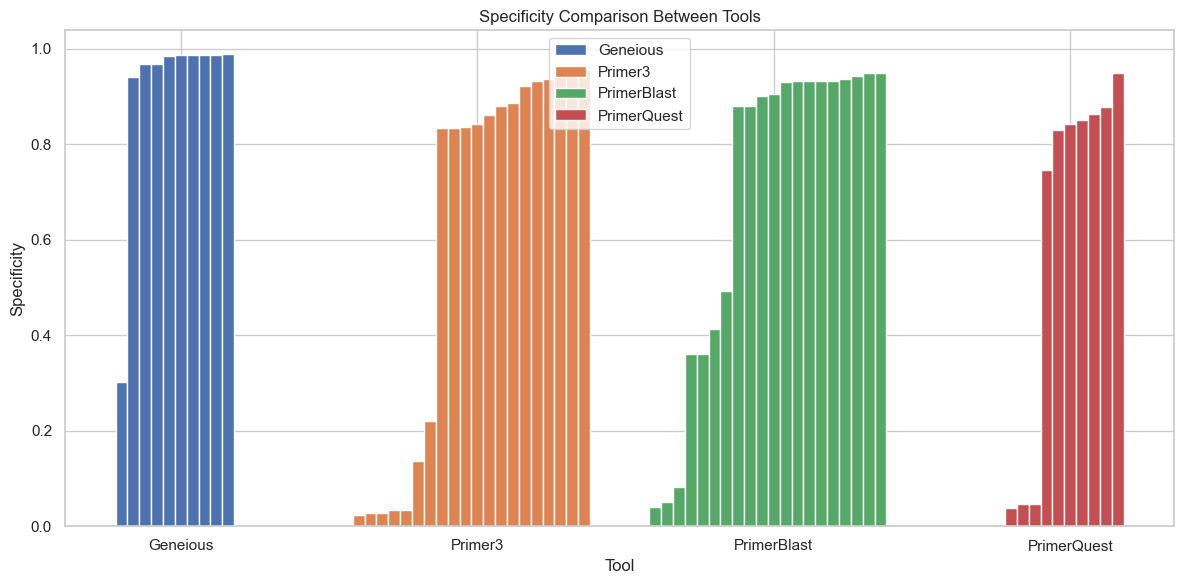

In [176]:
# Get unique tools
tools = combined_df['Tool'].unique()
num_tools = len(tools)

# Set figure size
plt.figure(figsize=(12, 6))

# Define bar width
bar_width = 0.04

# Create a position index for each tool
indices = np.arange(num_tools)

# Number of specificity scores per tool
num_scores = combined_df['Tool'].value_counts().max()

# Plot each specificity value as a separate bar within its tool group
for i, tool in enumerate(tools):
    tool_data = combined_df[combined_df['Tool'] == tool]['Specificity'].sort_values().values
    # Calculate offsets
    offsets = (np.arange(len(tool_data)) - len(tool_data)/2) * bar_width
    bar_positions = indices[i] + offsets
    plt.bar(bar_positions, tool_data, width=bar_width, label=tool)

# Set labels and title
plt.xlabel('Tool')
plt.ylabel('Specificity')
plt.title('Specificity Comparison Between Tools')
plt.xticks(indices, tools)
plt.legend()
plt.tight_layout()
plt.show()

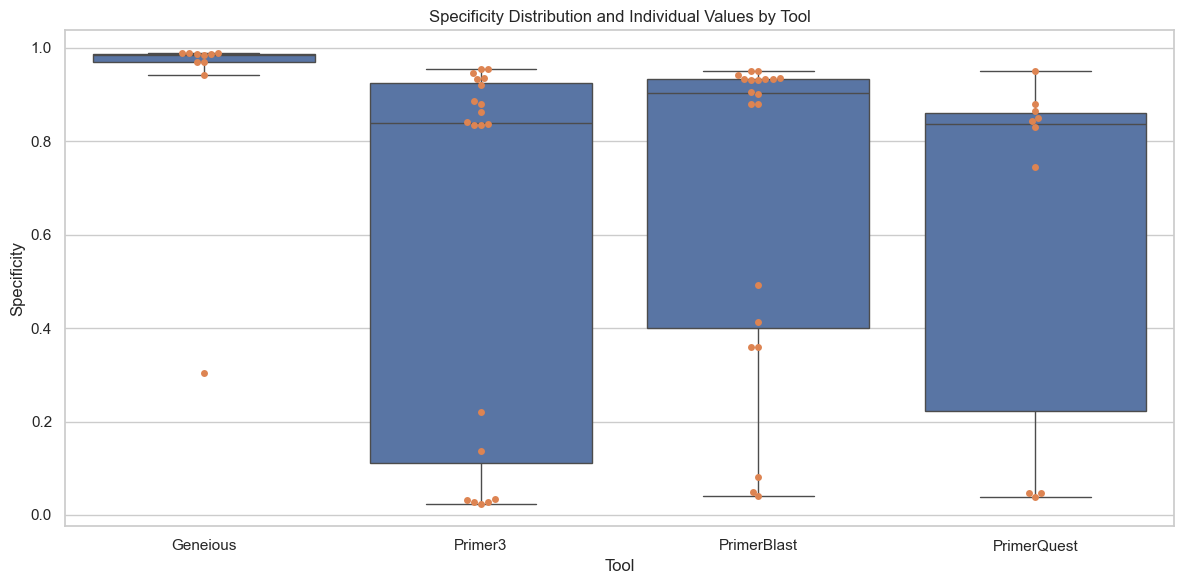

In [175]:
# Create a combined box and swarm plot without palette
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Tool',
    y='Specificity',
    data=combined_df,
    showcaps=True,
    boxprops={},
    showfliers=False  # Optional: Hide outliers for clarity
)
sns.swarmplot(
    x='Tool',
    y='Specificity',
    data=combined_df,
    
)
plt.title('Specificity Distribution and Individual Values by Tool')
plt.xlabel('Tool')
plt.ylabel('Specificity')
plt.tight_layout()
plt.show()

#### Comparison between other metrics

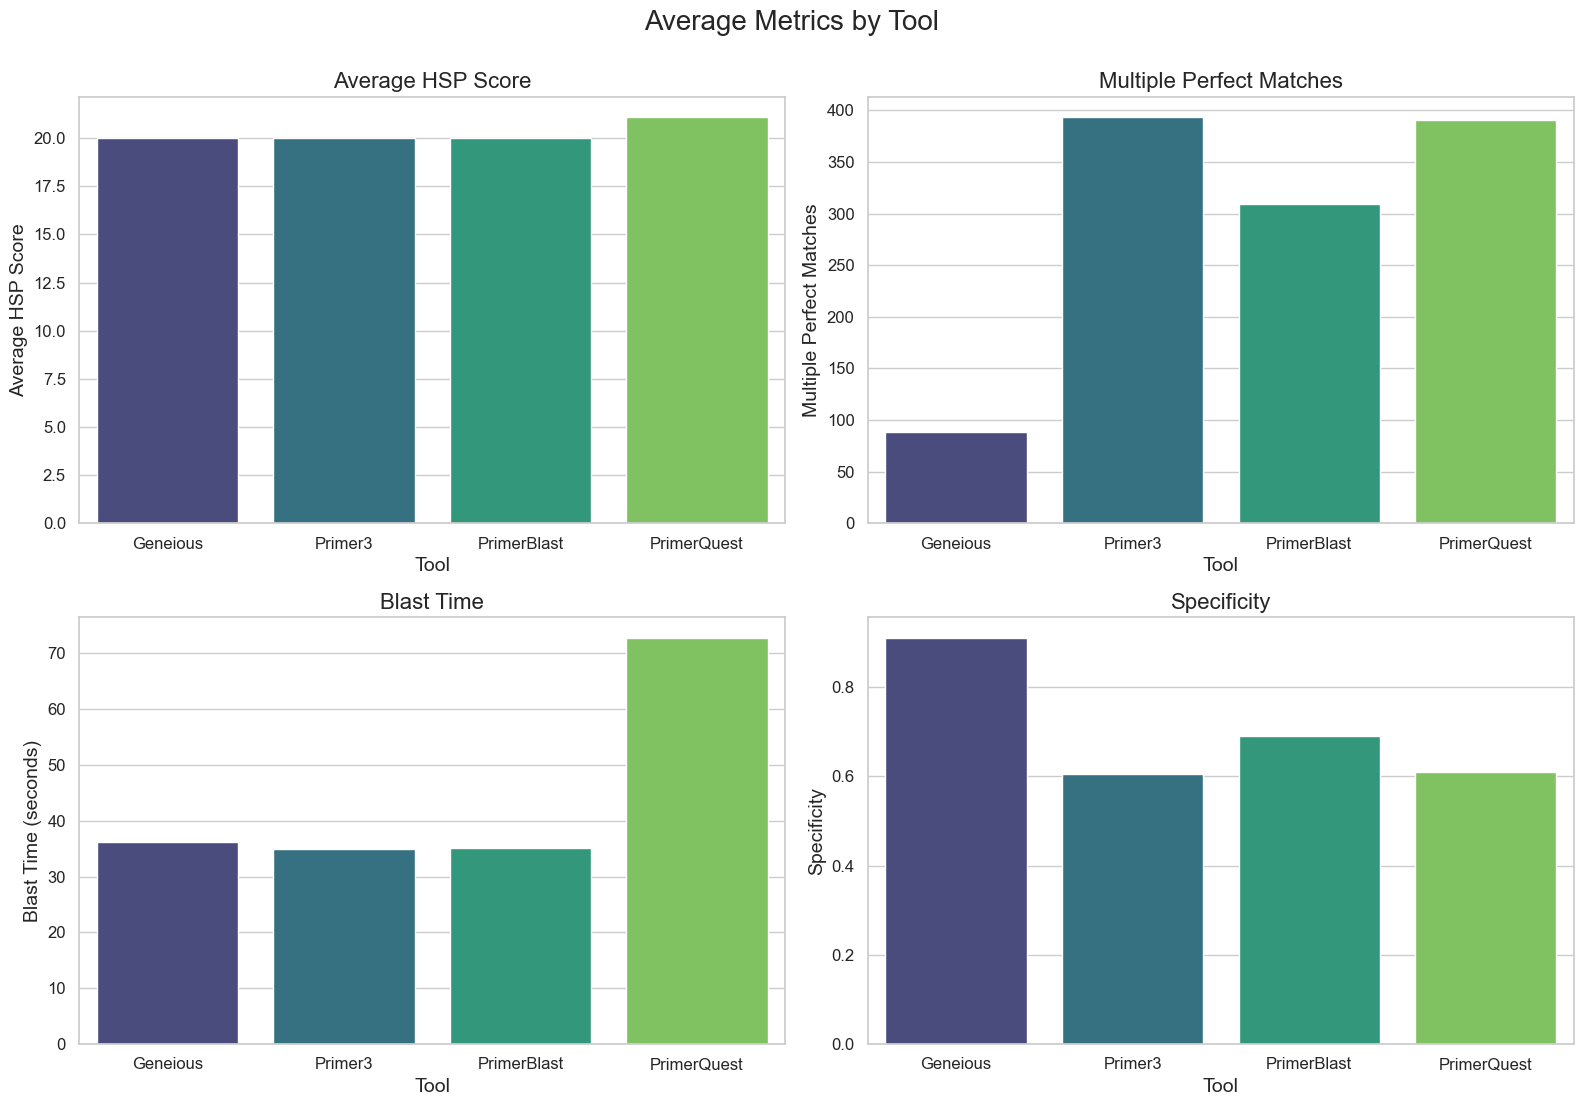

In [173]:


# Calculate the average of each metric grouped by 'Tool'
avg_metrics = combined_df.groupby('Tool')[['AverageHSPScore', 'MultiplePerfectMatches', 'BlastTime', 'Specificity']].mean().reset_index()


# Create subplots: 2 rows x 2 columns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Average Metrics by Tool', fontsize=20, y=0.95)

# Plot configurations
metrics = {
    'AverageHSPScore': {'title': 'Average HSP Score', 'ylabel': 'Average HSP Score'},
    'MultiplePerfectMatches': {'title': 'Multiple Perfect Matches', 'ylabel': 'Multiple Perfect Matches'},
    'BlastTime': {'title': 'Blast Time', 'ylabel': 'Blast Time (seconds)'},
    'Specificity': {'title': 'Specificity', 'ylabel': 'Specificity'}
}

# Flatten axes for easy iteration
axes = axes.flatten()

for idx, (metric, props) in enumerate(metrics.items()):
    sns.barplot(
        ax=axes[idx],
        x='Tool',
        y=metric,
        data=avg_metrics,
        palette='viridis',
        hue='Tool'
    )
    axes[idx].set_title(props['title'], fontsize=16)
    axes[idx].set_xlabel('Tool', fontsize=14)
    axes[idx].set_ylabel(props['ylabel'], fontsize=14)
    axes[idx].tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()